In [6]:
import numpy as np
import cv2
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.4.1


#Loading dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [8]:
import zipfile
path="drive/MyDrive/"
zip_ref = zipfile.ZipFile(path+"line_dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/255,
                                 rotation_range = 5,
                                 shear_range = 0.03,
                                 zoom_range = [0.98,1.1],
                                 horizontal_flip = False,
                                 vertical_flip = False,
                                 validation_split=0.2)

train_set = train_datagen.flow_from_directory(
        "/content/line_dataset",
        target_size=(64,64),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=4,
        shuffle= True,
        subset='training')
test_set = train_datagen.flow_from_directory(
        "/content/line_dataset",
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=4,
        class_mode='categorical',
        shuffle= True,
        subset='validation')

print(train_set.class_indices)

Found 638 images belonging to 6 classes.
Found 156 images belonging to 6 classes.
{'0_straight': 0, '1_x': 1, '2_T': 2, '3_left': 3, '4_right': 4, '5_end': 5}


In [10]:
GRAY_INPUT_SHAPE = (64, 64, 1)
NUM_CLASSES = 6
class_names = ['straight', 'x', 'T', 'left', 'right', 'end']

In [11]:
def preprocess(img,input_shape=GRAY_INPUT_SHAPE):
    img = cv2.resize(img, (input_shape[0],input_shape[1]))
    if input_shape[2]==1:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = np.array(np.reshape(img,input_shape),
                                      dtype=np.uint8)
    
    img_test = (np.expand_dims(img, axis = 0))
    img_test = img_test/255.
    return img_test

#A simple grayscale CNN classifier

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Model

model_gray= Sequential()
model_gray.add(Conv2D(32, (3, 3), input_shape = GRAY_INPUT_SHAPE, activation = 'relu' )) 
model_gray.add(MaxPooling2D(pool_size=(2,2))) 
model_gray.add(BatchNormalization()) 

model_gray.add(Conv2D(64, (3, 3), activation = 'relu')) 
model_gray.add(MaxPooling2D(pool_size = (2, 2))) 
model_gray.add(BatchNormalization())

model_gray.add(Conv2D(128, (3, 3), activation = 'relu')) 
model_gray.add(MaxPooling2D(pool_size = (2, 2))) 
model_gray.add(BatchNormalization())

model_gray.add(Flatten())
model_gray.add(Dense(units = 64, activation = 'relu'))  
model_gray.add(Dropout( rate = 0.2 ))
model_gray.add(Dense(units = 32, activation = 'relu'))  
model_gray.add(Dense(units = 16, activation = 'relu'))  

model_gray.add(Dense(units = NUM_CLASSES , activation = 'softmax')) 

In [19]:
model_gray.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 128)      

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=8, 
                      verbose=1, 
                      mode='auto')

model_gray.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                    metrics=['accuracy'])

history = model_gray.fit(
          train_set,
          steps_per_epoch=50,
          epochs=30,
          validation_data=test_set,
          validation_steps=20,
          shuffle = True,
          callbacks=[early])

Epoch 1/30
50/50 [==============================] - 4s 53ms/step - loss: 2.2045 - accuracy: 0.2270 - val_loss: 1.9316 - val_accuracy: 0.1125
Epoch 2/30
50/50 [==============================] - 2s 47ms/step - loss: 1.7421 - accuracy: 0.4580 - val_loss: 2.5844 - val_accuracy: 0.1000
Epoch 3/30
50/50 [==============================] - 2s 47ms/step - loss: 1.1100 - accuracy: 0.6033 - val_loss: 2.9601 - val_accuracy: 0.1000
Epoch 4/30
50/50 [==============================] - 2s 48ms/step - loss: 1.2345 - accuracy: 0.5589 - val_loss: 3.6956 - val_accuracy: 0.1375
Epoch 5/30
50/50 [==============================] - 2s 47ms/step - loss: 0.8925 - accuracy: 0.6563 - val_loss: 5.1410 - val_accuracy: 0.1875
Epoch 6/30
50/50 [==============================] - 2s 48ms/step - loss: 0.8899 - accuracy: 0.6985 - val_loss: 5.6932 - val_accuracy: 0.1625
Epoch 7/30
50/50 [==============================] - 2s 48ms/step - loss: 0.7441 - accuracy: 0.7694 - val_loss: 4.0913 - val_accuracy: 0.1750
Epoch 8/30
50

In [21]:
history.history

{'accuracy': [0.2929292917251587,
  0.4300000071525574,
  0.6161616444587708,
  0.5707070827484131,
  0.6549999713897705,
  0.7350000143051147,
  0.7599999904632568,
  0.7575757503509521,
  0.7979797720909119,
  0.7850000262260437,
  0.7575757503509521,
  0.8450000286102295,
  0.8349999785423279,
  0.8799999952316284,
  0.8349999785423279,
  0.8849999904632568,
  0.8550000190734863,
  0.8349999785423279,
  0.875,
  0.9049999713897705,
  0.925000011920929,
  0.8888888955116272,
  0.8949999809265137,
  0.8949999809265137,
  0.8899999856948853,
  0.9300000071525574,
  0.9399999976158142,
  0.9049999713897705,
  0.9599999785423279,
  0.9300000071525574],
 'loss': [2.1708011627197266,
  1.6360357999801636,
  1.1393519639968872,
  1.1816385984420776,
  0.944318413734436,
  0.840807318687439,
  0.7043262720108032,
  0.6870132684707642,
  0.5610242486000061,
  0.6145662069320679,
  0.7166757583618164,
  0.41420093178749084,
  0.4355483949184418,
  0.3130492866039276,
  0.6867541670799255,
  0.

In [23]:
results = model_gray.evaluate(test_set, batch_size=4)
print("test loss, test acc:", results)

39/39 [==============================] - 1s 18ms/step - loss: 0.4354 - accuracy: 0.9167
test loss, test acc: [0.43537184596061707, 0.9166666865348816]


(1, 64, 64, 1)
[[7.04735667e-02 5.61234128e-06 6.82490572e-05 1.16130595e-05
  1.03129787e-04 9.29337800e-01]]
The predicted class is: end


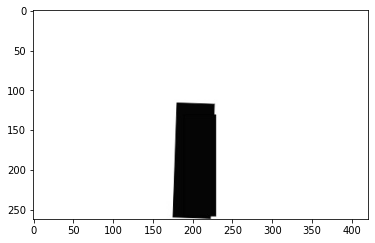

In [ ]:
img = cv2.imread('end2.jpg')

test_img = preprocess(img)
print(test_img.shape)
pyplot.imshow(img)
prediction = model_gray.predict(test_img)
print(prediction)
pred_index = np.argmax(prediction[0])
print('The predicted class is:', class_names[pred_index] )

In [24]:
model_gray.save("drive/MyDrive/grayscale_line_classifier")

INFO:tensorflow:Assets written to: drive/MyDrive/grayscale_line_classifier/assets


#Transfer Learning

In [27]:
INPUT_SHAPE = (128, 128, 3)
NUM_CLASSES = 6

base_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling=None)

94773248/94765736 [==============================] - 1s 0us/step


In [28]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen_rgb=ImageDataGenerator(rescale=1/255,
                                 rotation_range = 5,
                                 shear_range = 0.03,
                                 zoom_range = [0.98,1.1],
                                 horizontal_flip = False,
                                 vertical_flip = False,
                                 validation_split=0.2)

train_set_rgb = train_datagen_rgb.flow_from_directory(
        "/content/line_dataset",
        target_size=(128,128),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=4,
        shuffle= True,
        subset='training')
test_set_rgb = train_datagen.flow_from_directory(
        "/content/line_dataset",
        target_size=(128,128),
        color_mode='rgb',
        batch_size=4,
        class_mode='categorical',
        shuffle= True,
        subset='validation')

Found 638 images belonging to 6 classes.
Found 156 images belonging to 6 classes.


In [29]:
base_model.trainable = False
#base_model.summary()
inputs = keras.Input(shape=INPUT_SHAPE)

x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
flat1 = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(NUM_CLASSES,activation='softmax')(flat1)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 6150      
Total params: 25,692,038
Trainable params: 2,104,326
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=8, 
                      verbose=1, 
                      mode='auto')

model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
          train_set_rgb,
          steps_per_epoch=60,
          epochs=35,
          validation_data=test_set_rgb,
          validation_steps=20,
          shuffle = True,
          callbacks=[early])

Epoch 1/35
60/60 [==============================] - 26s 364ms/step - loss: 1.8954 - accuracy: 0.2694 - val_loss: 1.3548 - val_accuracy: 0.5000
Epoch 2/35
60/60 [==============================] - 21s 343ms/step - loss: 1.1254 - accuracy: 0.6130 - val_loss: 0.8406 - val_accuracy: 0.6500
Epoch 3/35
60/60 [==============================] - 20s 342ms/step - loss: 0.7591 - accuracy: 0.7836 - val_loss: 0.7222 - val_accuracy: 0.7875
Epoch 4/35
60/60 [==============================] - 20s 342ms/step - loss: 0.5889 - accuracy: 0.8527 - val_loss: 0.6040 - val_accuracy: 0.8000
Epoch 5/35
60/60 [==============================] - 21s 344ms/step - loss: 0.5136 - accuracy: 0.8563 - val_loss: 0.7004 - val_accuracy: 0.7500
Epoch 6/35
60/60 [==============================] - 20s 342ms/step - loss: 0.4824 - accuracy: 0.8276 - val_loss: 0.4826 - val_accuracy: 0.8625
Epoch 7/35
60/60 [==============================] - 20s 342ms/step - loss: 0.4213 - accuracy: 0.8879 - val_loss: 0.3580 - val_accuracy: 0.9000

In [31]:
results = model.evaluate(test_set_rgb, batch_size=4)
print("test loss, test acc:", results)

39/39 [==============================] - 10s 252ms/step - loss: 0.2653 - accuracy: 0.9487
test loss, test acc: [0.26528504490852356, 0.9487179517745972]


In [32]:
model.save("drive/MyDrive/resnet50_line_classifier")

INFO:tensorflow:Assets written to: drive/MyDrive/resnet50_line_classifier/assets


#Optimizing and converting model to tfLite

In [33]:
saved_model_dir = "drive/MyDrive/resnet50_line_classifier"

##For CPU:

In [34]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('model_resnet50.tflite', 'wb') as f:
  f.write(tflite_quant_model)

##For edge TPU compatibility:

In [ ]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((images)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

#Testing tfLite model inference with tfLite interpretter

[[8.7342328e-01 4.7582256e-05 6.7231787e-10 5.6731026e-04 3.9084390e-04
  1.2557094e-01]]
The predicted class is: straight


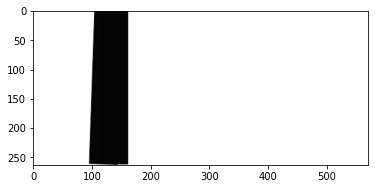

In [ ]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
#set random np array to test
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

img = cv2.imread('straight1.jpg')

test_img = preprocess(img)
pyplot.imshow(img)

input_data = np.array(test_img, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
pred_index = np.argmax(output_data[0])
print('The predicted class is:', class_names[pred_index] )

#Comparing the two models